In [1]:
%pylab 
from nugridpy import nugridse as mp
from nugridpy import mesa as ms
import matplotlib.pyplot as plt

# for plotting consistently with abu_profile
from nugridpy import utils as u

# use h5py to read and write h5 file
import h5py

data_dir="/data/nugrid_apod2"    

ms.set_nugrid_path(data_dir)
mp.set_nugrid_path(data_dir)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# get mesa data
star2 = ms.star_log(mass=2.0,Z=0.02)
star3 = ms.star_log(mass=3.0,Z=0.02)

# get post processing data
path2 = '/user/ast501/dstephens/mppnp/diffusion_mesa/mppnp_subtime_0/H5_out/'
path3 = '/user/ast501/dstephens/mppnp/3M_Run/H5_out/'
star2_pp = mp.se(path2,rewrite=True)
star3_pp = mp.se(path3,rewrite=True)

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Using old star.logsa file ...
 reading ...100% 

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 3.0
Using old star.logsa file ...
 reading ...100% 

Searching files, please wait.......
Writing preprocessor files
M2.00Z0.020.0053001.out.h5
M2.00Z0.020.0053501.out.h5
File search complete.
Searching files, please wait.......
Writing preprocessor files
M3.00Z0.020.0058501.out.h5
M3.00Z0.020.0059001.out.h5
File search complete.


## Mass = 2M$_{\odot}$

In [17]:
# make a kippenhahn diagram of the cycle of interest
plt.figure(1)
star2.kippenhahn_CO(1,'model')

plt.xlim([53000,54000])
plt.ylim([0.58,0.62])

# turn off legend
axis = plt.gca()
axis.get_legend().remove()

## Mg-25 Production

For checking the production between the two models, get an average across the maximum extent of the convection zone in mass fraction and plot it as a function of model number. This should coincide with the maximum temperature as a function of model number. See which mass star has the most significant amount of Mg-25 production as well as neutron mass fraction 

In [4]:
# define functions, make general enough for further use
def iso_mass_avg(iso_massf,mass_index):
    
    # iso massf is only one species for one model number
    # ensure that there aren't any SIGNIFCANT outliars in sample
    iso_massf = iso_massf[mass_index[0]:(mass_index[1]+1)]
    
#     # determine the 5sigma outliar
#     error = 5*np.std(iso_massf)
#     mean = np.mean(iso_massf)
    
#     average = 0
#     length = 0
    
#     for i in range(len(iso_massf)):
#         if abs(iso_massf[i] - mean) < error:
#             average += iso_massf[i]
#             length += 1
    
#     return average / float(length)
    return np.mean(iso_massf)

######################################################################################################
# define a function to use an iso_massf, isotope list and grab those data arrays
def find_iso(iso_massf,isotope_list,species_find):
    
    # isotope list contains all isotopes and species_fin contains what I'm looking for
    # find indices corresponding to species list
    iso_index = []
    for i in range(len(species_find)):
        for p in range(len(isotope_list)):
            if species_find[i] == isotope_list[p]:
                iso_index.append(p)
                break
    
    # create a list which will slice iso_massf
    iso_out = []
    for i in range(len(iso_index)):
        iso_out.append(iso_massf[:,iso_index[i]])
    
    # return iso_out
    return iso_out


# define function to get a 'quantity' for an h5py file of a given cycle/model number
def h5_quantity(h5_file,cycle,quantity):
    
    # quantity is a string which is the data I am looking for
    # cycle string format
    cycle_string = 'cycle00000' + str(int(cycle))
    data = h5_file[cycle_string]['SE_DATASET'][quantity]
    
    return data

# place in an array of mass quantities, look for [mass_find] and return mass_index
def find_mass_index(mass,mass_find):
    
    # mass is a singular mass array, need to find mass_find, may be multiple
    mass_index = []
    for i in range(len(mass_find)):
        mass_index.append(int(np.argmin(abs(mass - mass_find[i]))))
        
    # return the list
    return mass_index

# function to find a specific models schwarzschild boundaries in indices
def mass_bounds(star,model,mass):
    
    # WORKING WITH MODEL #, NEED TO USE PYTHON SLICING THOUGH
    # get the boundaries of mass for the convection zone
    star_mass = star.get('star_mass')[model-1]
    mix_bot = star.get('mx2_bot')[model-1] * star_mass
    mix_top = star.get('mx2_top')[model-1] * star_mass
    
    # find indices
    schwarz = []
    schwarz.append(int(np.argmin(abs(mass - mix_bot))))
    schwarz.append(int(np.argmin(abs(mass - mix_top))))
    
    # return
    return schwarz

    # function to find the maximum extent of convection zone as well as the average extent
def avg_mass_bounds(star,model_range):
    # just need the star objects, and the model range that the convection zone is contained in

    # get the mass ranges of convection boundary
    star_mass = star.get('star_mass')[model_range[0]:model_range[1]]
    mix_low = star.get('mx2_bot')[model_range[0]:model_range[1]]
    mix_high = star.get('mx2_top')[model_range[0]:model_range[1]]
    
    # find where they are zero or not
    convection_bounds = []
    for i in range(len(star_mass) - 1):
        
        # make sure that there is convection and that the next element doesnt stop
        if mix_low[i] >= 1e-9 and mix_low[i+1] >= 1e-9:
            convection_bounds.append(i)
            
    # slice the arrays to the appropriate size
    star_mass = star_mass[convection_bounds[0]:(convection_bounds[-1] + 1)]
    mix_low = mix_low[convection_bounds[0]:(convection_bounds[-1] + 1)] * star_mass
    mix_high = mix_high[convection_bounds[0]:(convection_bounds[-1] + 1)] * star_mass
    
    # make sure that if there
    
    # return the max convection bounds as well as average AND new model range
    max_bounds = [min(mix_low),max(mix_high)]
    avg_bounds = [np.mean(mix_low),np.mean(mix_high)]
    model_range = [model_range[0] + convection_bounds[0], model_range[0] + convection_bounds[-1]]
    
    return max_bounds, avg_bounds, model_range

In [5]:
# for the convection zone size, determine the average abundance of Mg-25 before and after convection zone
model_range = [53000,53900]

# grab the max_min bounds
max_min_bounds, avg_bounds, model_range = avg_mass_bounds(star2,model_range)

In [6]:
# start looping 20 models before convection
models2 = list(range(model_range[0]-20,model_range[1]))
species = ['Neutron-1','Ne-22','Mg-25','Zr-94','Zr-96']
isotope_list = star2_pp.se.isotopes

# create array to hold averaged mass fractions
avg_iso_massf2 = np.zeros((len(species),len(models2)))
avg_density2 = np.zeros((len(species),len(models2)))
avg_volume2 = np.zeros(len(models2))
max_temp2 = np.zeros(len(models2))

for i in range(len(models2)):
    
    # grab the iso_massf
    iso_massf = star2_pp.get(models2[i],'iso_massf')
    mass = star2_pp.get(models2[i],'mass')
    rho = star2_pp.get(models2[i],'rho')
    radius = star2_pp.get(models2[i],'radius')
    temperature = star2_pp.get(models2[i],'temperature')
    
    # check for fucked up stuff
    if len(iso_massf) < 4:
        iso_massf = iso_massf[1]
    if len(mass) < 4:
        mass = mass[1]
    if len(rho) < 4:
        rho = rho[1]
    if len(radius) < 4:
        radius = radius[1]
    if len(temperature) < 4:
        temperature = temperature[1]
        
    # make the smaller iso_massf based on species
    iso_massf = find_iso(iso_massf,isotope_list,species)
    
    # find mass index for the convection zone of this particular model
    bot_index = find_mass_index(mass,[max_min_bounds[0]])
    top_index = find_mass_index(mass,[max_min_bounds[1]])
    
    mass_index = [bot_index[0],top_index[0]]
    
    # get the volume across the bounds
    avg_volume2[i] = (4/3. * np.pi) * (np.power(radius[top_index[0]],3.0) - np.power(radius[bot_index[0]],3.0))
    
    # get the maximum temperature within the convection zone max extent
    max_temp2[i] = np.max(1e9 * temperature[bot_index[0]:(top_index[0]+1)])
    
    
    # get the average neutron density
#     avg_density[i] = np.mean(iso_massf[0][bot_index[0]:(top_index[0]+1)] * rho[bot_index[0]:top_index[0]+1])
    
    # loop through all species
    for p in range(len(species)):
        
        # get the mass average
        avg_iso_massf2[p][i] = iso_mass_avg(iso_massf[p],mass_index)
        avg_density2[p][i] = iso_mass_avg(iso_massf[p]*rho,mass_index)

 reading ['temperature']...100%

<IPython.core.display.Javascript object>


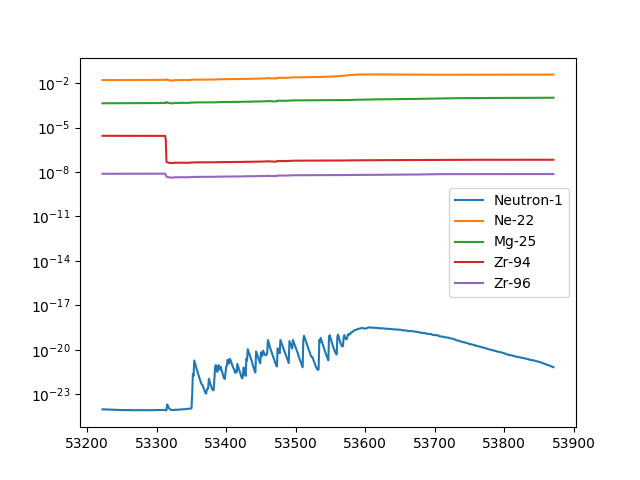

In [10]:
# try plotting
plt.figure(22)

for i in range(len(species)):
    plt.semilogy(models2,avg_iso_massf2[i],label=species[i])
    
plt.legend()

<IPython.core.display.Javascript object>


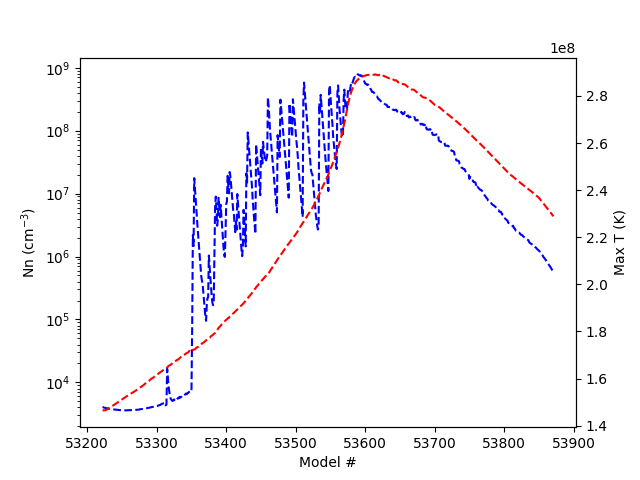

In [11]:
# make a plot of neutron density (g/cm^3)
neutron_mass = 1.674929e-27 * 1e3
neutron_num = avg_density2[0] / neutron_mass

# make the plot
fig = plt.figure(4)
ax = fig.add_subplot(111)

ax.semilogy(models2,neutron_num,'b--')

# add labels
ax.set_ylabel(r'Nn (cm$^{-3}$)')
ax.set_xlabel('Model #')

# create second axis for highest temperature
ax2 = ax.twinx()
ax2.plot(models2,max_temp2,'r--')

# add labels
ax2.set_ylabel('Max T (K)')

<IPython.core.display.Javascript object>


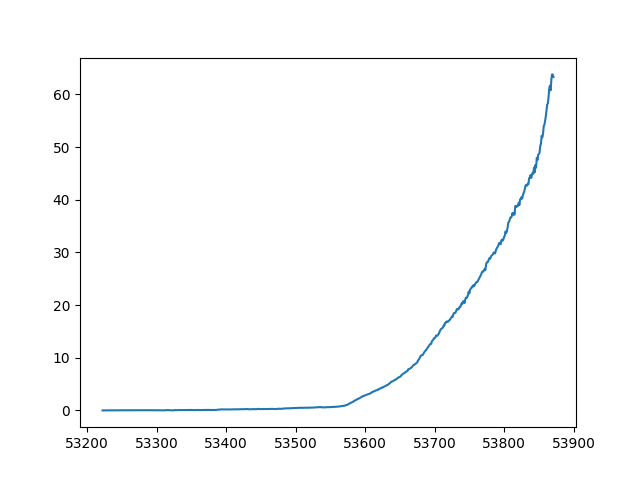

In [12]:
# get absolute mass production of MG 25 relative to the mass BEFORE convection zone
Mg_base = avg_density2[2][0] * avg_volume2[0] * (6.95e8 * 1e2)**3

# get the magnesium production as a percent difference
Mg_production = np.zeros(len(models2))

for i in range(len(models2)):
    Mg_production[i] = abs(avg_density2[2][i] * avg_volume2[i] * (6.95e8 * 1e2)**3 - Mg_base) / Mg_base

# make the plot
plt.figure(64)

plt.plot(models2,Mg_production)

In [ ]:
# save data to a file (takes a long time to run this stuff)
f = open('2M_Average.txt','w')
f.write('# Model #, volume (Rsun^3), max_temp (K),')

# write the density for species
f.write('[Density: ')
for i in range(len(species)):
    if i == len(species) - 1:
        f.write(species[i] + '],')
    else:
        f.write(species[i] + ',')

# write the species mass fractions
f.write('[Massf: ')
for i in range(len(species)):
    if i == len(species) - 1:
        f.write(species[i] + ']\n')
    else:
        f.write(species[i] + ',')

# write in csv format
for i in range(len(models2)):
    
    f.write(str(models2[i])+ ',')
    f.write(str(avg_volume2[i]) + ',')
    f.write(str(max_temp2[i]) + ',')
    
    # write species densities
    for p in range(len(species)):
        f.write(str(avg_density2[p][i]) + ',')
    
    # write species massf
    for p in range(len(species)):
        if p == len(species) - 1:
             f.write(str(avg_iso_massf2[p][i]) + '\n')
        else:
            f.write(str(avg_iso_massf2[p][i]) + ',')

## M = 3M$_{\odot}$

<IPython.core.display.Javascript object>


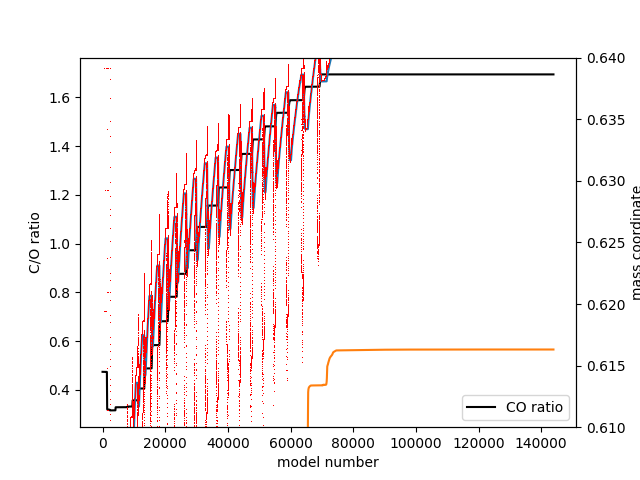

In [7]:
# make a kippenhahn diagram of the cycle of interest
plt.figure(5)
star3.kippenhahn_CO(5,'model')

# plt.xlim([58000,60000])
plt.ylim([0.61,0.64])

# turn off legend
axis = plt.gca()
axis.get_legend().remove()

In [8]:
# for the convection zone size, determine the average abundance of Mg-25 before and after convection zone
model_range = [58500,59250]

# grab the max_min bounds
max_min_bounds, avg_bounds, model_range = avg_mass_bounds(star3,model_range)

In [9]:
# start looping 5 models before convection
models3 = list(range(model_range[0] - 5,model_range[1]))
species = ['Neutron-1','Ne-22','Mg-25','Zr-94','Zr-96']
isotope_list = star3_pp.se.isotopes

# create array to hold averaged mass fractions
avg_iso_massf3 = np.zeros((len(species),len(models3)))
avg_density3 = np.zeros((len(species),len(models3)))
avg_volume3 = np.zeros(len(models3))
max_temp3 = np.zeros(len(models3))

for i in range(len(models3)):
    
    # grab the iso_massf
    iso_massf = star3_pp.get(models3[i],'iso_massf')
    mass = star3_pp.get(models3[i],'mass')
    rho = star3_pp.get(models3[i],'rho')
    radius = star3_pp.get(models3[i],'radius')
    temperature = star3_pp.get(models3[i],'temperature')
    
    # check for fucked up stuff
    if len(iso_massf) < 4:
        iso_massf = iso_massf[1]
    if len(mass) < 4:
        mass = mass[1]
    if len(rho) < 4:
        rho = rho[1]
    if len(radius) < 4:
        radius = radius[1]
    if len(temperature) < 4:
        temperature = temperature[1]
        
    # make the smaller iso_massf based on species
    iso_massf = find_iso(iso_massf,isotope_list,species)
    
    # find mass index for the convection zone of this particular model
    bot_index = find_mass_index(mass,[max_min_bounds[0]])
    top_index = find_mass_index(mass,[max_min_bounds[1]])
    
    mass_index = [bot_index[0],top_index[0]]
    
    # get the volume across the bounds
    avg_volume3[i] = (4/3. * np.pi) * (np.power(radius[top_index[0]],3.0) - np.power(radius[bot_index[0]],3.0))
    
    # get the maximum temperature within the convection zone max extent
    max_temp3[i] = np.max(1e9 * temperature[bot_index[0]:(top_index[0]+1)])
    
    
    # get the average neutron density
#     avg_density[i] = np.mean(iso_massf[0][bot_index[0]:(top_index[0]+1)] * rho[bot_index[0]:top_index[0]+1])
    
    # loop through all species
    for p in range(len(species)):
        
        # get the mass average
        avg_iso_massf3[p][i] = iso_mass_avg(iso_massf[p],mass_index)
        avg_density3[p][i] = iso_mass_avg(iso_massf[p]*rho,mass_index)

 reading ['temperature']...100%

<IPython.core.display.Javascript object>


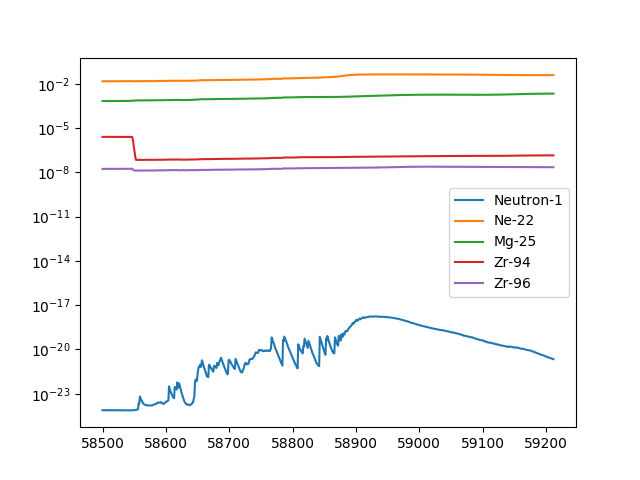

In [13]:
# try plotting
plt.figure(9)

for i in range(len(species)):
    plt.semilogy(models3,avg_iso_massf3[i],label=species[i])
    
plt.legend()

<IPython.core.display.Javascript object>


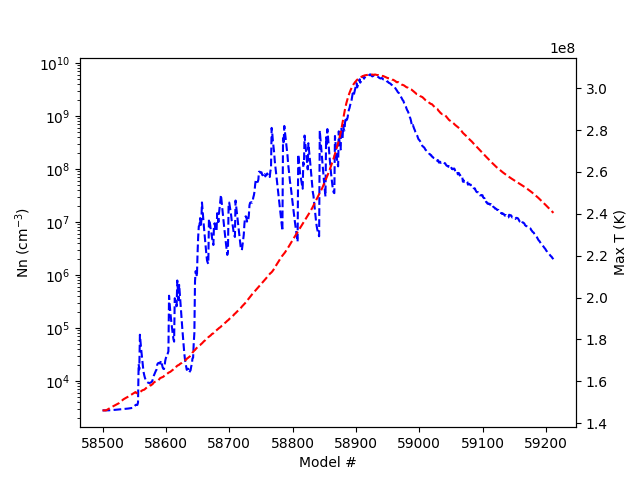

In [14]:
# make a plot of neutron density (g/cm^3)
neutron_mass = 1.674929e-27 * 1e3
neutron_num = avg_density3[0] / neutron_mass

# make the plot
fig = plt.figure(100)
ax = fig.add_subplot(111)

ax.semilogy(models3,neutron_num,'b--')

# add labels
ax.set_ylabel(r'Nn (cm$^{-3}$)')
ax.set_xlabel('Model #')

# create second axis for highest temperature
ax2 = ax.twinx()
ax2.plot(models3,max_temp3,'r--')

# add labels
ax2.set_ylabel('Max T (K)')

<IPython.core.display.Javascript object>


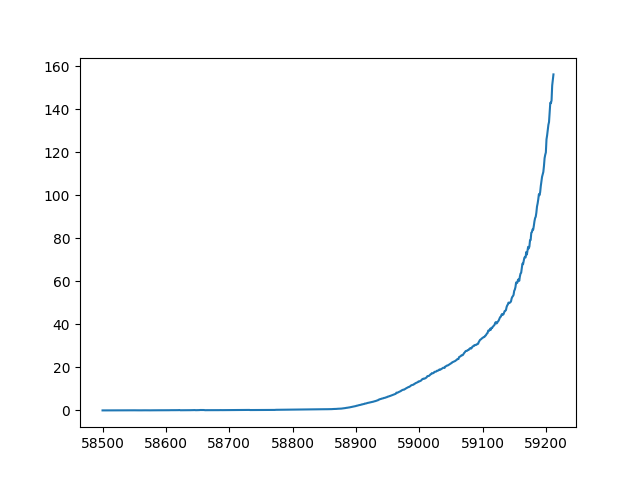

In [15]:
# get absolute mass production of MG 25 relative to the mass BEFORE convection zone
Mg_base = avg_density3[2][0] * avg_volume3[0] * (6.95e8 * 1e2)**3

# get the magnesium production as a percent difference
Mg_production = np.zeros(len(models3))

for i in range(len(models3)):
    Mg_production[i] = abs(avg_density3[2][i] * avg_volume3[i] * (6.95e8 * 1e2)**3 - Mg_base) / Mg_base

# make the plot
plt.figure(66)

plt.plot(models3,Mg_production)

In [ ]:
# save data to a file (takes a long time to run this stuff)
f = open('3M_Average.txt','w')
f.write('# Model #, volume (Rsun^3), max_temp (K),')

# write the density for species
f.write('[Density: ')
for i in range(len(species)):
    if i == len(species) - 1:
        f.write(species[i] + '],')
    else:
        f.write(species[i] + ',')

# write the species mass fractions
f.write('[Massf: ')
for i in range(len(species)):
    if i == len(species) - 1:
        f.write(species[i] + ']\n')
    else:
        f.write(species[i] + ',')

# write in csv format
for i in range(len(models3)):
    
    f.write(str(models3[i])+ ',')
    f.write(str(avg_volume3[i]) + ',')
    f.write(str(max_temp3[i]) + ',')
    
    # write species densities
    for p in range(len(species)):
        f.write(str(avg_density3[p][i]) + ',')
    
    # write species massf
    for p in range(len(species)):
        if p == len(species) - 1:
             f.write(str(avg_iso_massf3[p][i]) + '\n')
        else:
            f.write(str(avg_iso_massf3[p][i]) + ',')